In [1]:
import os
os.system(r'python C:\users\barby\documents\github\runs\upload_activities.py')
import psycopg2
import datetime

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from bokeh.io import output_notebook, show, reset_output
from bokeh.plotting import figure
from bokeh.palettes import all_palettes
from bokeh.embed import file_html
from bokeh.resources import CDN
from bokeh.models import DatetimeTickFormatter, Range1d, WheelZoomTool, HoverTool, ColumnDataSource, CustomJS
from bokeh.models import Arrow, VeeHead, Label, Text, Legend, BoxAnnotation

%matplotlib inline

km_in_a_mile = 1.60934

def readConfig(key):
    config = pd.read_table(r'c:\users\barby\documents\config.txt', header = None)
    config = [c.split('=') for c in config[0]]
    out = [c[1] for c in config if c[0] == key][0]
    return(out)

def dbGetQuery(q):
    pw = readConfig('pw')
    conn_string = "host='kavdb.c9lrodma91yx.us-west-2.rds.amazonaws.com' dbname='kavdb' user='lkavenagh' password='" + pw + "'"
    conn = psycopg2.connect(conn_string)
    conn.autocommit = True
    dat = pd.read_sql(q, conn)
    conn.close()
    return(dat)

# YTD activities

In [2]:
dat = dbGetQuery("SELECT * FROM runs.activities")
dat = dat.sort_values('start_date')

dat = dat.append(dat.tail(1)).reset_index(drop = True)
dat.loc[len(dat)-1, 'start_date'] = datetime.datetime.now()
dat.loc[len(dat)-1, 'distance'] = 0

dat['year'] = [c.year for c in dat.start_date]
dat['doy'] = [c.timetuple().tm_yday for c in dat.start_date]

dat['distance_miles'] = [(c/1000)/km_in_a_mile for c in dat.distance]
dat['ytd_distance'] = dat.groupby('year', as_index = False).cumsum()['distance_miles']
dat['generic_date'] = [datetime.date(1900,c.month,c.day) for c in dat.start_date]


In [3]:
target = 800

dat = dat[['start_date', 'generic_date', 'year', 'ytd_distance', 'distance_miles', 'doy', 'type']]

actual = dat.loc[dat.start_date == max(dat.start_date), 'ytd_distance'].item()

plot_dat = dat[['generic_date', 'year', 'ytd_distance']]
plot_dat = plot_dat.groupby(['generic_date', 'year'], as_index = False).max()
plot_dat = plot_dat.pivot_table(index = 'generic_date', columns = 'year')
plot_dat.columns = plot_dat.columns.droplevel().rename(None)
plot_dat = plot_dat.reset_index()
plot_dat = plot_dat.apply(lambda series: series.loc[:series.last_valid_index()].ffill())

x = range(len(plot_dat))
y = [(target / len(plot_dat)) * x for x in x]
plot_dat['target'] = y
t = datetime.datetime.today().date()
today_target = plot_dat.loc[plot_dat.generic_date == datetime.date(1900, t.month, t.day), 'target'].item()

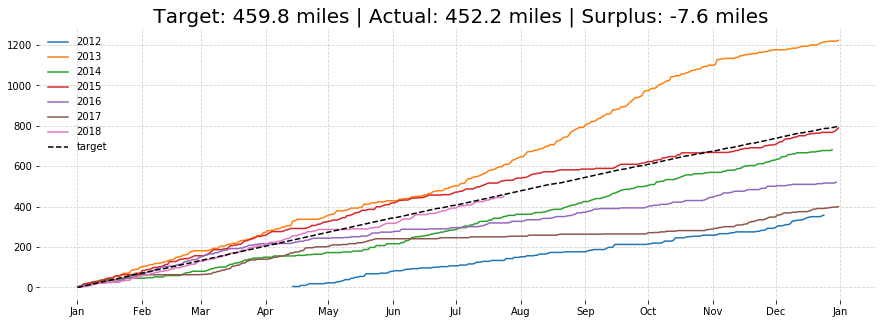

In [4]:
fig = plt.figure(figsize = (15,5))
ax = fig.add_subplot(111)

for y in plot_dat.columns[1:]:
    if y == 'target':
        ax.plot(plot_dat.generic_date, plot_dat[y], linestyle = '--', color = 'k')
    else:
        ax.plot(plot_dat.generic_date, plot_dat[y])

ax.legend(frameon = False)
for var in ['top', 'bottom', 'left', 'right']:
    ax.spines[var].set_visible(False)
    
ax.grid(linestyle = '--', color = 'lightgrey')

ax.set_title(' Target: ' + str(round(today_target,1)) + ' miles |' + \
            ' Actual: ' + str(round(actual,1)) + ' miles |' + \
            ' Surplus: ' + str(round(actual - today_target,1)) + ' miles', fontsize = 20)

ax.set_xticks([datetime.date(1900,c,1) for c in range(1,13)] + [datetime.date(1901,1,1)])
xfmt = mdates.DateFormatter('%b')
ax.xaxis.set_major_formatter(xfmt)

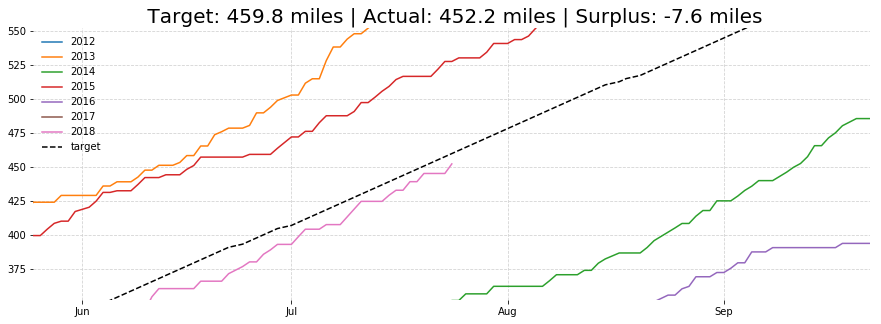

In [5]:
fig = plt.figure(figsize = (15,5))
ax = fig.add_subplot(111)

for y in plot_dat.columns[1:]:
    if y == 'target':
        ax.plot(plot_dat.generic_date, plot_dat[y], linestyle = '--', color = 'k')
    else:
        ax.plot(plot_dat.generic_date, plot_dat[y])

ax.legend(frameon = False)
for var in ['top', 'bottom', 'left', 'right']:
    ax.spines[var].set_visible(False)
    
ax.grid(linestyle = '--', color = 'lightgrey')

ax.set_xticks([datetime.date(1900,c,1) for c in range(1,13)] + [datetime.date(1901,1,1)])

maxdate = plot_dat.loc[plot_dat[plot_dat.columns[-2]] == np.nanmax(plot_dat[plot_dat.columns[-2]]), 'generic_date'].head(1).item()
ax.set_xlim(maxdate - datetime.timedelta(60), maxdate + datetime.timedelta(60))

maxdistance = np.nanmax(plot_dat[plot_dat.columns[-2]])
ax.set_ylim(max(maxdistance - 100,0), maxdistance + 100)

ax.set_title(' Target: ' + str(round(today_target,1)) + ' miles |' + \
            ' Actual: ' + str(round(actual,1)) + ' miles |' + \
            ' Surplus: ' + str(round(actual - today_target,1)) + ' miles', fontsize = 20)

xfmt = mdates.DateFormatter('%b')
ax.xaxis.set_major_formatter(xfmt)

# Monthly average pace

In [6]:
dat = dbGetQuery("SELECT start_date, average_speed, distance FROM runs.activities WHERE type = 'Run' and average_speed > 2.1")
dat = dat.sort_values('start_date')
dat['month'] = [datetime.date(c.year, c.month, 1) for c in dat.start_date]
dat['average_pace'] = [(km_in_a_mile/60)/((0.00001+c) / 1000) for c in dat.average_speed]
dat.distance = [(c/1000)/km_in_a_mile for c in dat.distance]

In [7]:
out = pd.DataFrame(columns = ['date', 'average_pace_7', 'average_pace_30', 'average_pace_YTD'])

for i in range(len(dat)):
    dat_7 = dat.loc[(dat.start_date < dat.start_date[i]) & (dat.start_date >= (dat.start_date[i] - datetime.timedelta(7)))]
    dat_30 = dat.loc[(dat.start_date < dat.start_date[i]) & (dat.start_date >= (dat.start_date[i] - datetime.timedelta(30)))]
    dat_YTD = dat.loc[(dat.start_date < dat.start_date[i]) & (dat.start_date >= datetime.date(dat.start_date[i].year,1,1))]

    pace_y = pace_30 = pace_YTD = None
    if len(dat_7) > 0:
        pace_7 = np.nansum(dat_7.distance * dat_7.average_pace) / np.nansum(dat_7.distance)
    if len(dat_30) > 0:
        pace_30 = np.nansum(dat_30.distance * dat_30.average_pace) / np.nansum(dat_30.distance)
    if len(dat_YTD) > 0:
        pace_YTD = np.nansum(dat_YTD.distance * dat_YTD.average_pace) / np.nansum(dat_YTD.distance)

    out = out.append(pd.DataFrame([[dat.start_date[i].date(),
                            pace_7,
                            pace_30,
                            pace_YTD]], columns = ['date', 'average_pace_7', 'average_pace_30', 'average_pace_YTD']
                         ))
out = out.sort_values('date')

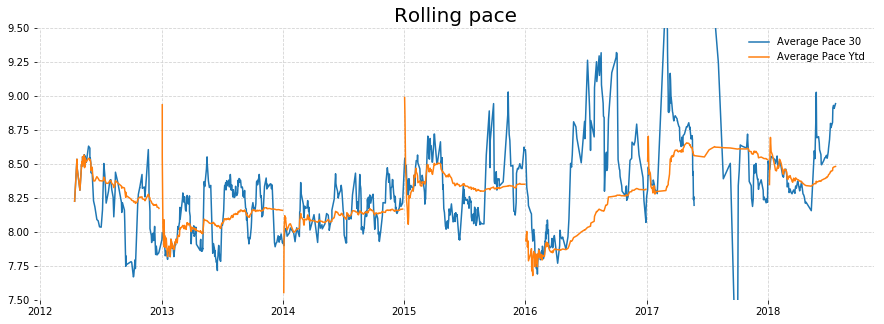

In [8]:
fig = plt.figure(figsize = (15,5))
ax = fig.add_subplot(111)

for y in out.columns[2:]:
    ax.plot(out.date, out[y], label = y.replace('_', ' ').title())

ax.legend(frameon = False)
for var in ['top', 'bottom', 'left', 'right']:
    ax.spines[var].set_visible(False)
    
ax.grid(linestyle = '--', color = 'lightgrey')
ax.set_title('Rolling pace', fontsize = 20)
ax.set_ylim(7.5, 9.5)

xfmt = mdates.DateFormatter('%Y')
ax.xaxis.set_major_formatter(xfmt)

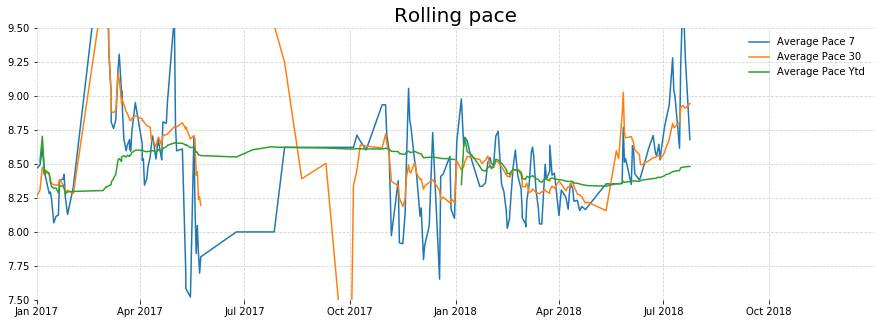

In [9]:
fig = plt.figure(figsize = (15,5))
ax = fig.add_subplot(111)

for y in out.columns[1:]:
    ax.plot(out.date, out[y], label = y.replace('_', ' ').title())

ax.legend(frameon = False)
for var in ['top', 'bottom', 'left', 'right']:
    ax.spines[var].set_visible(False)
    
ax.grid(linestyle = '--', color = 'lightgrey')

ax.set_title('Rolling pace', fontsize = 20)
ax.set_xlim(datetime.date(max(out.date).year-1, 1, 1), datetime.date(max(out.date).year, 12, 31))
ax.set_ylim(7.5,9.5)
xfmt = mdates.DateFormatter('%b %Y')
ax.xaxis.set_major_formatter(xfmt)

# Monthly elevation gain

In [10]:
dat = dbGetQuery("SELECT start_date, total_elevation_gain FROM runs.activities")
dat = dat.sort_values('start_date')
dat['month'] = [datetime.date(c.year, c.month, 1) for c in dat.start_date]
dat = dat.groupby('month', as_index = False).sum()
dat = dat.sort_values('month')

dat.month = [c.strftime('%b-%y') for c in dat.month]
dat = dat.reset_index(drop = True)

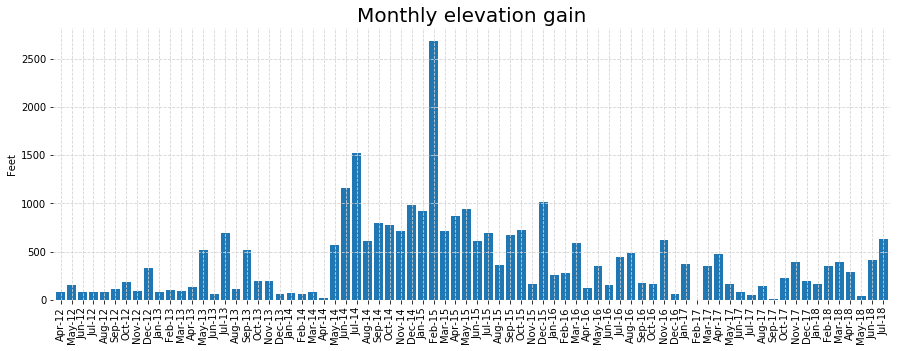

In [11]:
fig = plt.figure(figsize = (15,5))
ax = fig.add_subplot(111)

dat = dat.set_index('month')
dat.plot(kind = 'bar', ax = ax, width = 0.8)

ax.legend_.remove()
for var in ['top', 'bottom', 'left', 'right']:
    ax.spines[var].set_visible(False)

ax.set_xlabel('')
ax.set_ylabel('Feet')
ax.set_title('Monthly elevation gain', fontsize = 20)
ax.grid(linestyle = '--', color = 'lightgrey')

# Monthly mileage

In [12]:
dat = dbGetQuery("SELECT start_date, distance FROM runs.activities")
dat.distance = [(c/1000)/km_in_a_mile for c in dat.distance]
dat = dat.sort_values('start_date')
dat['month'] = [datetime.date(c.year, c.month, 1) for c in dat.start_date]
dat = dat.groupby('month', as_index = False).sum()
dat = dat.sort_values('month')
dat.month = [c.strftime('%b-%y') for c in dat.month]
dat = dat.reset_index(drop = True)

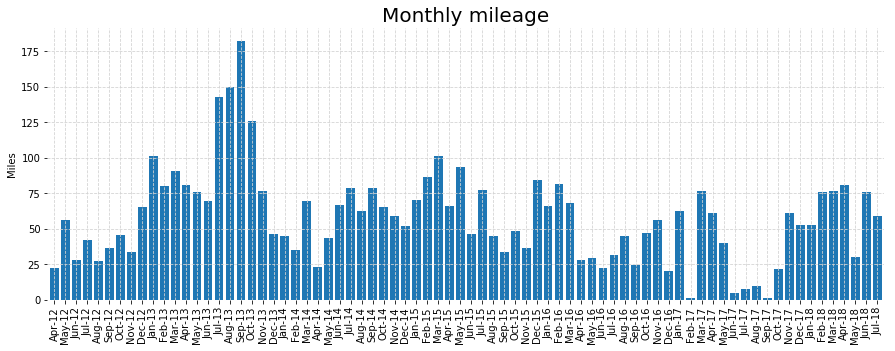

In [13]:
fig = plt.figure(figsize = (15,5))
ax = fig.add_subplot(111)

dat = dat.set_index('month')
dat.plot(kind = 'bar', ax = ax, width = 0.8)

ax.legend_.remove()
for var in ['top', 'bottom', 'left', 'right']:
    ax.spines[var].set_visible(False)

ax.set_xlabel('')
ax.set_ylabel('Miles')
ax.set_title('Monthly mileage', fontsize = 20)
ax.grid(linestyle = '--', color = 'lightgrey')